# Discrete examples

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../discrete_mixflows/')
from discrete_mixflows import *
from gibbs import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 24})

## 1D toy example

First we generate a one-dimensional synthetic example
where $\pi$ is a distribution over $\{1,\dots,10\}$.
We approximate $\pi$ with a MAD Mix $q_N$
of depth $N=500$ and with a uniform reference 
$q_0\sim\mathsf{U}\{1,\dots10\}$.
We also target $\pi$ with a standard Gibbs sampler
run for 50,000 iterations, where only the last 500 are kept.

Below we show a plot of the exact density $q_N(x)$ compared to $\pi(x)$,
along with a histogram of samples from the Gibbs sampler.

In [2]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (1,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x])
    return ext_lprb

In [3]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : np.log(1/K1)*np.ones(x.shape[1])
def randq0(size): return np.random.randint(0,K1,size).reshape(1,size),np.random.rand(1,size)

N=500 # number of steps in qN
xi=np.pi/16

# evaluate density
x=np.array(np.arange(0,K1)[np.newaxis,:],dtype=int)
u=np.random.rand(1,K1)
qvar=np.exp(lqN(x,u,N,lq0,lp,xi))

In [4]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.random.randint(low=0,high=K1)*np.ones(1)
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

Text(0, 0.5, 'probability')

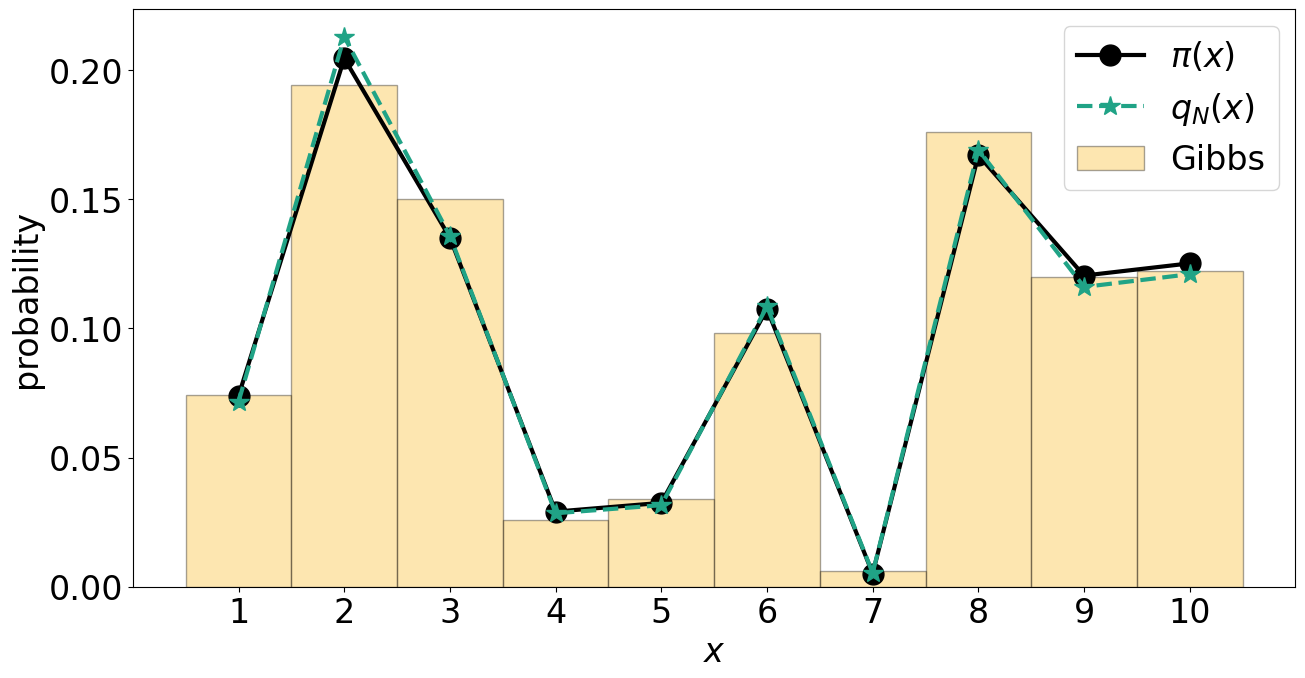

In [5]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,K1)
#plt.bar(ttx+0.5,prbs, alpha=0.5, label=r'$\pi(x)$',color="black")
#plt.bar(ttx+0.5,qvar, alpha=0.5, label=r'$q_N(x)$',color="blue")
plt.plot(ttx+0.5,prbs,c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,qvar/np.sum(qvar),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.ylabel('probability')

In [6]:
gibbs_density=plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1),
                       alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')[0]
plt.clf()
elbo_qN=elbo_exact(np.log(qvar/np.sum(qvar)),np.log(prbs))
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))

ELBO(qN||π)=-0.00040329033243014217
ELBO(qGibbs||π)=-0.002063302048339602


<Figure size 1500x750 with 0 Axes>

## 2D toy example

Now we generate a two-dimensional synthetic example
where $\pi$ is a distribution over 
$\mathcal{X}=\{1,\dots,4\}\times\{1,\dots,5\}$.
We approximate $\pi$ with a MAD Mix $q_N$
of depth $N=500$ and with a uniform reference 
$q_0\sim\mathsf{U}(\mathcal{X})$.
We also target $\pi$ with a standard Gibbs sampler
run for 50,000 iterations, where only the last 500 are kept.

Below we show plots of the exact marginal densities $q_N(x_m)$ compared to $\pi(x_m)$,
$m=1,2$, along with a corresponding histogram of samples from the Gibbs sampler.

In [7]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=4
K2=5
prbs=np.random.rand(K1,K2)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    ext_lprb=np.log(np.moveaxis(np.repeat(prbs[:,:,np.newaxis],x.shape[1],axis=-1),2,0)) # stack d copies of logp vertically
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x[0,:],x[1,:]]) # for each d, return lp(x)
    if axis==0: return ext_lprb[np.arange(0,x.shape[1]),:,x[1,:]]
    if axis==1: return ext_lprb[np.arange(0,x.shape[1]),x[0,:],:]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [8]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
lq0 = lambda x,u : -np.log(K1*K2)*np.ones(x.shape[1])
def randq0(size): return np.vstack((np.random.randint(0,K1,size),np.random.randint(0,K2,size))).T,np.random.rand(size,size)

N=500 # number of steps in qN
xi=np.pi/16

# evaluate density
# first create a grid of values of x1 and x2
# adapted from https://stackoverflow.com/questions/27286537/numpy-efficient-way-to-generate-combinations-from-given-ranges
x = np.mgrid[0:K1,0:K2] 
x = np.rollaxis(x, 0, 3)
x = x.reshape((K1*K2,2)).T
myx=np.copy(x)
# now sample u and evaluate density
u=np.random.rand(2,K1*K2)
qvar=np.exp(lqN(x,u,N,lq0,lp,xi))
myqvar=qvar.reshape(prbs.shape) # to move back from (K1*K2,) to (K1,K2) array

In [9]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
x0=np.array([np.random.randint(low=0,high=K1),np.random.randint(low=0,high=K2)])
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

Text(0, 0.5, 'probability')

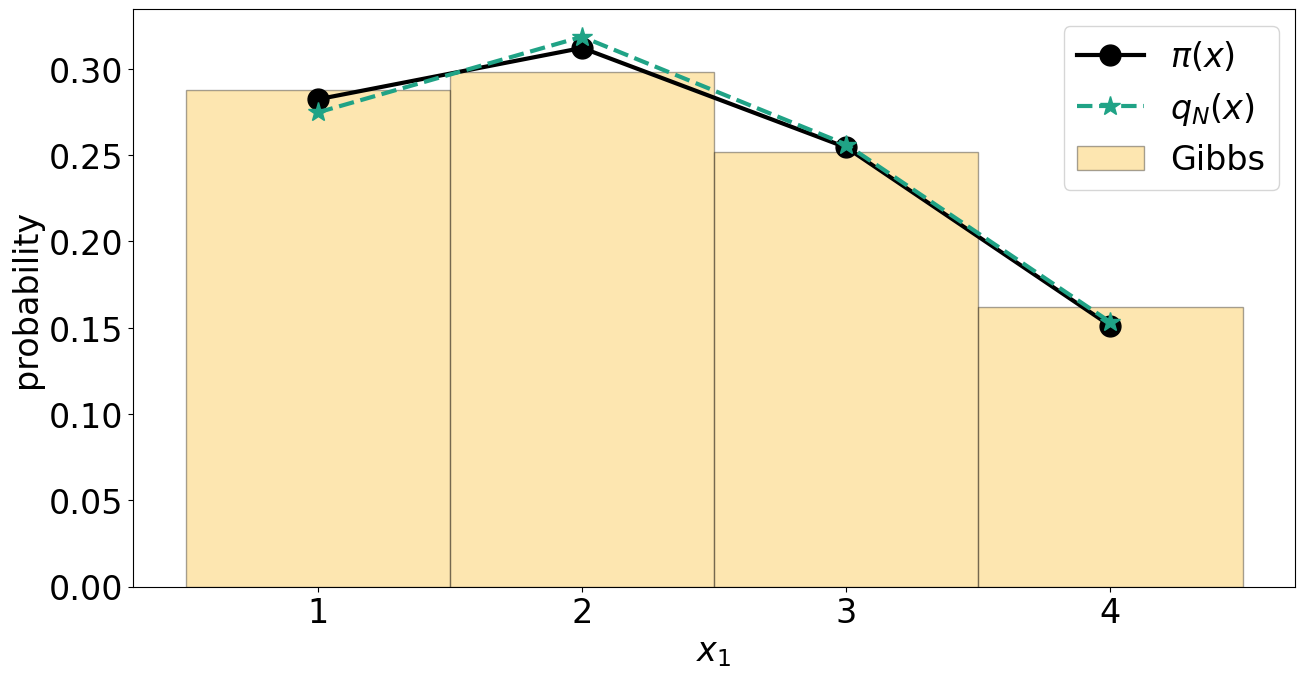

In [10]:
########################
########################
#   plot x1 results    #
########################
########################

ttx=np.arange(0,K1)
plt.plot(ttx+0.5,np.sum(prbs,axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar,axis=1),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,K1+1),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,K1)+0.5,labels=np.arange(1,1+K1))
plt.ylabel('probability')

Text(0, 0.5, 'probability')

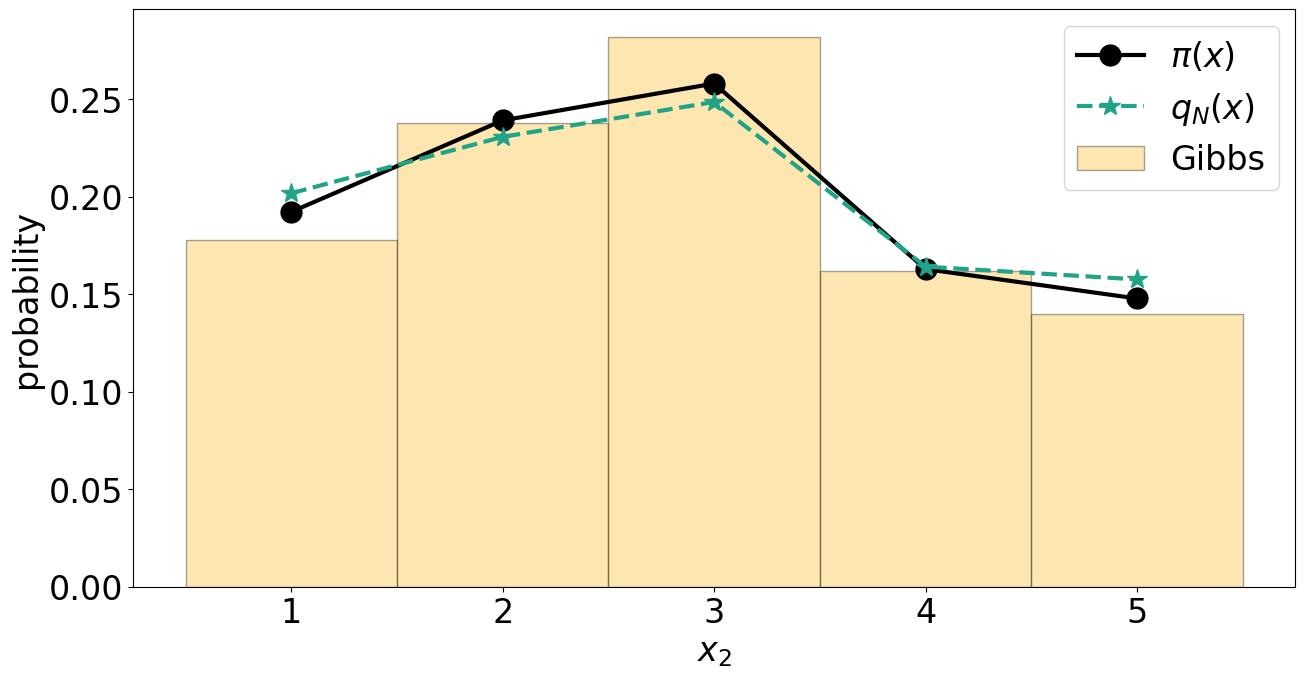

In [11]:
########################
########################
#   plot x2 results    #
########################
########################

ttx=np.arange(0,K2)
plt.plot(ttx+0.5,np.sum(prbs,axis=0),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar,axis=0),c='#20A386FF', label=r'$q_N(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[1,:],density=True,bins=np.arange(0,K2+1),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,K2)+0.5,labels=np.arange(1,1+K2))
plt.ylabel('probability')

In [12]:
gibbs_density=plt.hist2d(gibbs_samples[0,:],gibbs_samples[1,:],density=True,
                         bins=[np.arange(0,K1+1),np.arange(0,K2+1)],
                         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')[0]
plt.clf()
elbo_qN=elbo_exact(np.log(myqvar/np.sum(myqvar)),np.log(prbs))
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))

ELBO(qN||π)=-0.002000021625141389
ELBO(qGibbs||π)=-0.012151424983941169


<Figure size 1500x750 with 0 Axes>

## Bimodal example

In [53]:
########################
########################
# target specification #
########################
########################
eps=1e-16
mu=np.array([4,15]) # the two modes
def aux_gausslp(aux): return -0.5*(np.arange(0,20)-mu[aux][:,np.newaxis])**2-0.5*np.log(2*np.pi)
def aux_gausslp_1d(y,x): return -0.5*(y-mu[x])**2-0.5*np.log(2*np.pi)

def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    y=x[0,:]
    aux=x[1,:]
    
    if axis==None: return -0.5*(y-mu[aux])**2-0.5*np.log(2*np.pi)#1.
    if axis==0: return aux_gausslp(aux)
    if axis==1: 
        wlpy0=aux_gausslp_1d(y,0)+np.log(0.5)
        wlpy1=aux_gausslp_1d(y,1)+np.log(0.5)
        m=np.maximum(wlpy0,wlpy1)
        lpy=m+np.log(np.exp(wlpy0-m)+np.exp(wlpy1-m))
        #out=np.log1p(-eps)*np.ones((y.shape[0],2))
        #out[y>=10,0]=np.log(eps)
        #out[y<10,1]=np.log(eps)
        #out=0.5*np.ones((y.shape[0],2))
        out=np.ones((y.shape[0],2))
        out[:,0]=wlpy0
        out[:,1]=wlpy1
        return out-lpy[:,np.newaxis]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [54]:
########################
########################
#    MAD Mix approx    #
########################
########################

# reference specification
def lq0_0(x,u):
    out=-0.5*(x[0,:]-mu[0])**2-0.5*np.log(2*np.pi)
    out[x[1,:]==0]=np.log(1e-32)
    return out
def lq0_1(x,u):
    out=-0.5*(x[0,:]-mu[1])**2-0.5*np.log(2*np.pi)
    out[x[1,:]==1]=np.log(1e-32)
    return out

N=100 # number of steps in qN
xi=np.pi/16

# evaluate density
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)
#myx=np.copy(x)
u=np.random.rand(2,40)

# mode 1
qvar0=np.exp(lqN(x,u,N,lq0_0,lp,xi))
myqvar0=np.zeros((20,2))
myqvar0[:,0]=qvar0[:20]
myqvar0[:,1]=qvar0[20:]

# mode 2
#u=np.random.rand(2,40)
qvar1=np.exp(lqN(x,u,N,lq0_1,lp,xi))
myqvar1=np.zeros((20,2))
myqvar1[:,0]=qvar1[:20]
myqvar1[:,1]=qvar1[20:]

In [55]:
########################
########################
#    Gibbs sampling    #
########################
########################
N=500
x0=np.array([15,1])
gibbs_samples=gibbs_sampler(x0=x0,steps=N,lp=lp,burnin_pct=0.99,verbose=True)

In [56]:
mylp=np.exp(lp(x))
prbs=np.zeros((20,2))
prbs[:,0]=mylp[:20]
prbs[:,1]=mylp[20:]
prbs=prbs/np.sum(prbs)

Text(0, 0.5, 'probability')

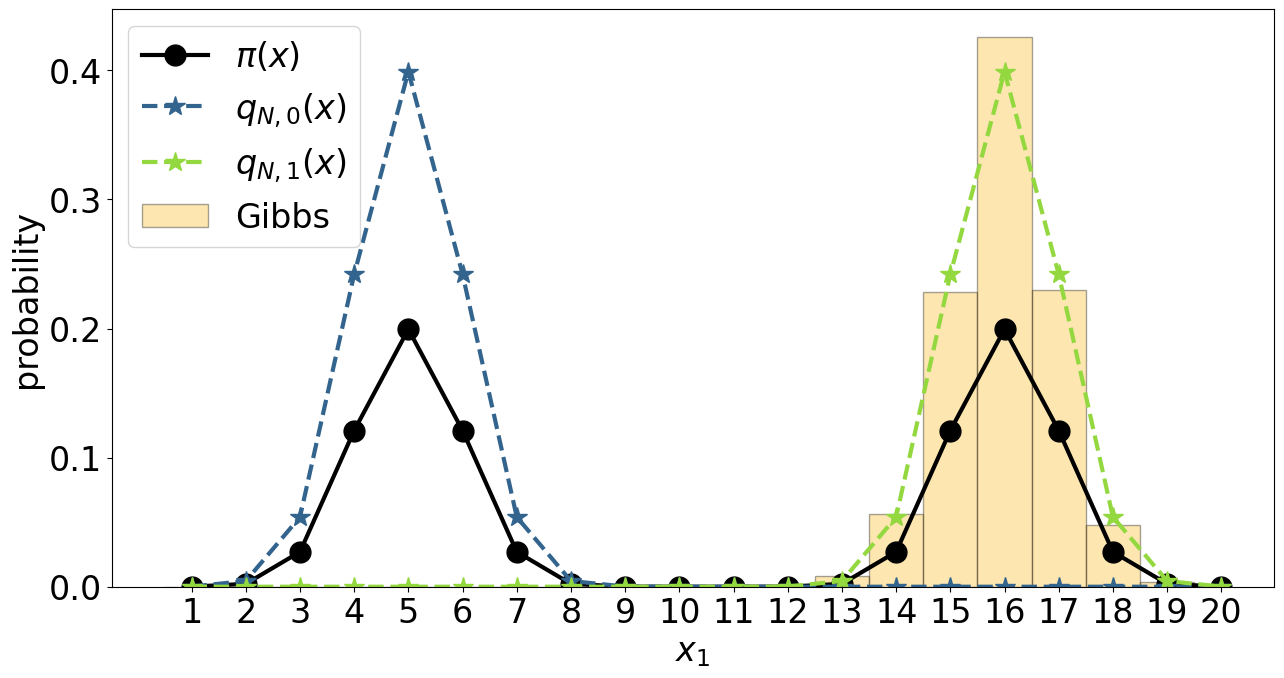

In [58]:
ttx=np.arange(0,20)
plt.plot(ttx+0.5,np.sum(prbs/np.sum(prbs),axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar0/np.sum(myqvar0),axis=1),c='#32648EFF', label=r'$q_{N,0}(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.plot(ttx+0.5,np.sum(myqvar1/np.sum(myqvar1),axis=1),c='#94D840FF', label=r'$q_{N,1}(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,20),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend()
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,20)+0.5,labels=np.arange(1,21))
plt.ylabel('probability')

### KL-optimal weighting

In [59]:
###############################
###############################
# variational family settings #
###############################
###############################

N=100 # number of steps in qN
xi=np.pi/16
lq0 = lambda x : lqN(x,np.random.rand(2,40),N,lq0_0,lp,xi)
lq1 = lambda x : lqN(x,np.random.rand(2,40),N,lq0_1,lp,xi)
def lq(x,w):
    exp1=lq0(x)+np.log(w)
    exp2=lq1(x)+np.log1p(-w)
    m=np.maximum(exp1,exp2)
    return m+np.log(np.exp(exp1-m)+np.exp(exp2-m))


# init x grid and fixed densities
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)
lq0_fixed=lq0(x)
lq1_fixed=lq1(x)

In [60]:
######################
######################
#    optimization    #
######################
######################

# optimization settings
np.random.seed(2023)
max_iter=10
gamma=1e1
w=np.random.rand()
print('Initial w: '+str(w))
print()
print('Iter  |          w          |   gradient')

for t in range(max_iter):
    #print(str(t+1)+'/'+str(max_iter),end='\r')
    gradient=np.sum((np.exp(lq0_fixed)-np.exp(lq1_fixed))*(lq(x,w)-lp(x)))
    w=w-gradient*gamma/np.sqrt(t+1)
    w=min(1-1e-16,max(1e-16,w)) # constrain to (0,1)
    print('  '+str(t+1)+'   | '+str(w)+'  | '+str(gradient))
# end for

Initial w: 0.32198830399196776

Iter  |          w          |   gradient
  1   | 0.39645312489679513  | -0.007446482090482737
  2   | 0.4261703673133021  | -0.0042026527261753155
  3   | 0.44334612865467316  | -0.0029749291301932046
  4   | 0.45472575358469974  | -0.0022759249860053177
  5   | 0.46284688882789177  | -0.001815941045824665
  6   | 0.468925160858617  | -0.001488866499310737
  7   | 0.47362929089907635  | -0.0012445958221963538
  8   | 0.4773621305297664  | -0.0010558064863771255
  9   | 0.48038257362733483  | -0.0009061329292705256
  10   | 0.4828652743616986  | -0.0007850989069162206


In [61]:
weighted_q=np.exp(lq(x,w))
myqvar=np.zeros((20,2))
myqvar[:,0]=weighted_q[20:]
myqvar[:,1]=weighted_q[:20]

Text(0, 0.5, 'probability')

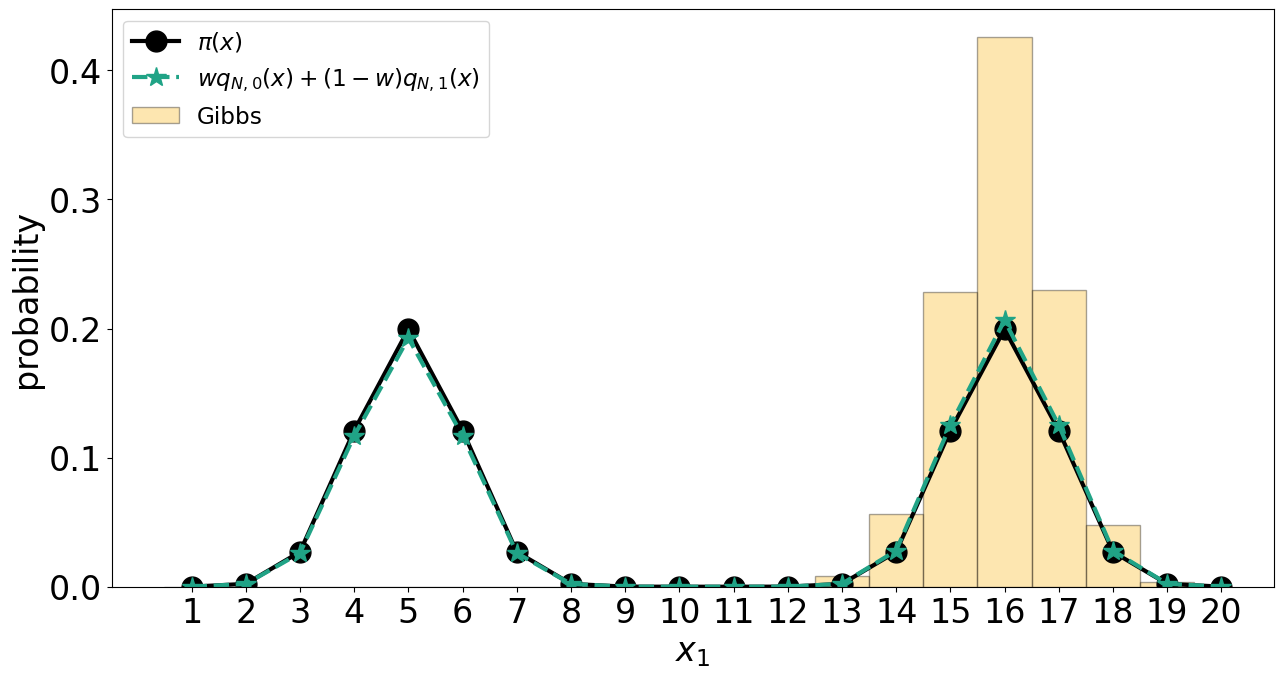

In [62]:
ttx=np.arange(0,20)
plt.plot(ttx+0.5,np.sum(prbs/np.sum(prbs),axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(myqvar/np.sum(myqvar),axis=1),c='#20A386FF', 
         label=r'$wq_{N,0}(x)+(1-w)q_{N,1}(x)$',lw=3,ls='dashed',ms=15,marker='*')
plt.hist(gibbs_samples[0,:],density=True,bins=np.arange(0,20),
         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')
plt.legend(fontsize='x-small')
plt.xlabel(r'$x_1$')
plt.xticks(ticks=np.arange(0,20)+0.5,labels=np.arange(1,21))
plt.ylabel('probability')

In [63]:
# optimal weight density
opt_weighted_q=np.exp(lq(x,0.5))
wstar_qvar=np.zeros((20,2))
wstar_qvar[:,0]=opt_weighted_q[20:]
wstar_qvar[:,1]=opt_weighted_q[:20]

In [64]:
gibbs_density=plt.hist2d(gibbs_samples[0,:],gibbs_samples[1,:],density=True,
                         bins=[np.arange(0,21),np.arange(0,3)],
                         alpha=0.35, label='Gibbs', color="#FBB91FFF",ec='black')[0]
plt.clf()
gibbs_density[gibbs_density<1e-32]=1e-64
elbo_qstar=elbo_exact(np.log(wstar_qvar/np.sum(wstar_qvar)),np.log(prbs))
elbo_qN=elbo_exact(np.log(myqvar/np.sum(myqvar)),np.log(prbs))
elbo_gibbs=elbo_exact(np.log(gibbs_density),np.log(prbs))
print('ELBO(q*||π)='+str(elbo_qstar))
print('ELBO(qN||π)='+str(elbo_qN))
print('ELBO(qGibbs||π)='+str(elbo_gibbs))

ELBO(q*||π)=-2.417727712317125e-11
ELBO(qN||π)=-0.0005873142092884288
ELBO(qGibbs||π)=-0.7008146175525383


<Figure size 1500x750 with 0 Axes>